In [1]:
import re
import sys
import os
import os.path
sys.path.append('../python')
import latex_plots

import numpy as np
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline

import matplotlib.pyplot as plt



import plot_info
from plot_info import showAndSave
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import copy
import json
import traceback

plot_info.set_notebook_name("bv.ipynb")

In [2]:
def load_bv(filename):
    bvs = []
    
    with netCDF4.Dataset(filename) as f:
        for variable, variable_data in f.variables.items():
            if variable != 'time':
                bvs.append(variable_data[0,0,0])
        
        return np.mean(bvs), np.std(bvs)
    
def get_time(filename):
    with netCDF4.Dataset(filename) as f:
        return f.variables['time'][0]
    
    
def legend_fixed_right():
    # with the errorbar, the ordering of the legend can be a bit
    # weird, this function fixes that
    ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if len(handles)%2 != 0:
        raise ValueError(f"Expected divisble by two! Got {len(handles)} entries in legend")


    new_handles = []
    new_labels = []

    for i in range(len(handles)//2):
        new_handles.append(handles[len(handles)//2+i])
        new_handles.append(handles[i])

        new_labels.append(labels[len(handles)//2+i])
        new_labels.append(labels[i])

    ax.legend(new_handles, new_labels,
              loc='center left', bbox_to_anchor=(1, 0.5))

In [3]:
configurations = {}

# add all fbb 
for H in [0.125, 0.5, 0.75]:
    configurations[f'fBb $H={H}$'] = f'../experiments_full_time_average/fbb_short_time/H{str(H).replace(".", "_")}/N{{resolution}}/euler_fbb_functional_bv_{{p}}_{{t}}.nc'

# kelvin-helmholtz
configurations[f'KH $\\epsilon=0.6$'] = f'../experiments_full_time_average/kh/p0_06/N{{resolution}}/kh_functional_bv_{{p}}_{{t}}.nc'

# richtmeyer-meshkov
configurations[f'RM $\\epsilon=0.06$'] = f'../experiments_full_time_average/rm/p0_06/N{{resolution}}/rm_functional_bv_{{p}}_{{t}}.nc'
        
# cloudshock
configurations[f'CS $\\epsilon=0.06$'] = f'../experiments_full_time_average/cloudshock/p0_06/N{{resolution}}/cloudshock_functional_bv_{{p}}_{{t}}.nc'

# shockvortex
configurations[f'SV $\\epsilon=0.06$'] = f'../experiments_full_time_average/shockvortex/p0_06/N{{resolution}}/shockvortex_functional_bv_{{p}}_{{t}}.nc'




/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


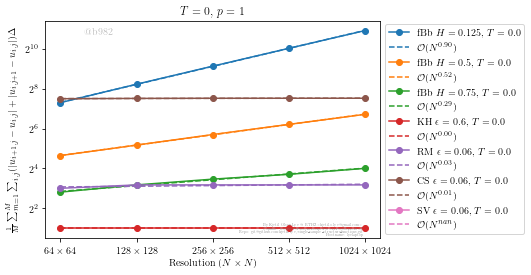

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


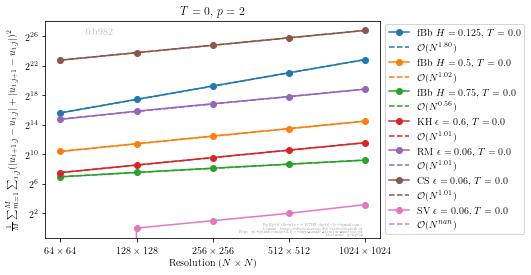

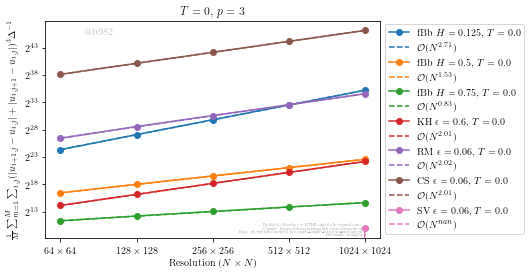

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


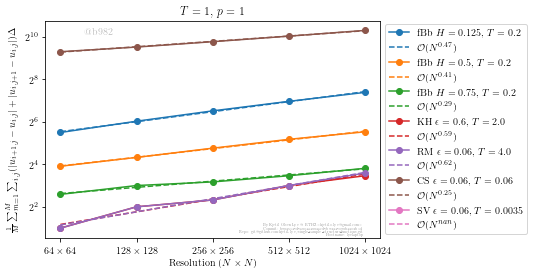

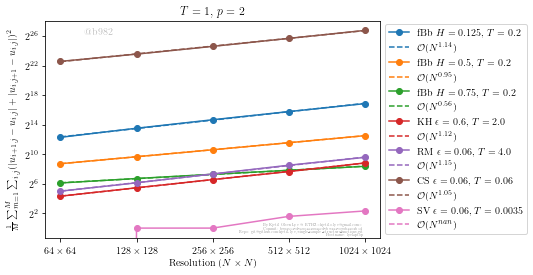

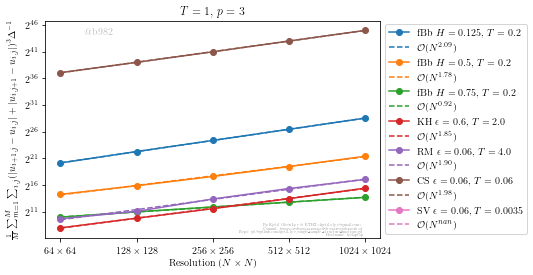

In [4]:
for time in [0, 1]:
    for p in [1, 2, 3]:
        resolutions = 2**np.arange(6,11)
        
        for configuration_name, basename_configuration in configurations.items():
            bv = np.zeros_like(resolutions)
            bv_std = np.zeros_like(resolutions)
            for n, resolution in enumerate(resolutions):
                dx_factor = (1.0 / resolution)**(2-p)
                filename = basename_configuration.format(p=p, resolution=resolution, t=time)
                bv[n], bv_std[n] = load_bv(filename)
                bv[n] *= dx_factor
                bv_std[n] *= dx_factor
            
                time_real = get_time(filename)
            
            plot_ref = plt.loglog(resolutions, bv, '-o', label=f'{configuration_name}, $T={time_real}$')
            plt.xscale('log', basex=2)
            plt.yscale('log', basey=2)
            poly = np.polyfit(np.log(resolutions), np.log(bv), 1)
            
            plt.loglog(resolutions, np.exp(poly[1])*resolutions**poly[0], '--',
                       label=f'$\\mathcal{{O}}(N^{{{poly[0]:0.2f}}})$', 
                      basex=2, basey=2, color=plot_ref[0].get_color())
        plt.xticks(resolutions, [f'${N}\\times{N}$' for N in resolutions])
        plt.xlabel('Resolution ($N\\times N$)')
        
        dx_factor_latex = f'\\Delta^{{{2-p}}}'  if p != 2 else ""
        if p != 1:
            plt.ylabel(f'$\\frac{{1}}{{M}}\\sum_{{m=1}}^M \\sum_{{i,j}} (|u_{{i+1,j}}-u_{{i,j}}|+|u_{{i,j+1}}-u_{{i,j}}|)^{{{p}}}{dx_factor_latex}$')
        else:
            plt.ylabel(f'$\\frac{{1}}{{M}}\\sum_{{m=1}}^M \\sum_{{i,j}} (|u_{{i+1,j}}-u_{{i,j}}|+|u_{{i,j+1}}-u_{{i,j}}|)\\Delta$')
        plt.title(f'$T={time}$, $p={p}$')
        plot_info.legendLeft()
        plot_info.showAndSave(f'bv_{configuration_name}_{time}_{p}')
                                